# EDA: Анализ данных аренды самокатов
*сезон апрель–октябрь 2024*

In [21]:
# Импорт библиотек
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Загрузка и первичный обзор данных

In [3]:
# Загрузка данных
path = 'kicksharing.csv'
df = pd.read_csv(path)

print(f" Размер данных: {df.shape}")
print(f" Период данных: апрель-октябрь 2024")

# Базовая информация
print("\n СТРУКТУРА ДАННЫХ:")
df.info()

# Анализ пропусков
print("\n АНАЛИЗ ПРОПУСКОВ:")
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Количество': missing_data, 'Доля %': missing_percent})
missing_df = missing_df[missing_df['Количество'] > 0]
display(missing_df)

 Размер данных: (396749, 20)
 Период данных: апрель-октябрь 2024

 СТРУКТУРА ДАННЫХ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             3967

,Количество,Доля %
loyalty_accrual_bns_amt,374801,94.470
education_level_cd,206690,52.100
marital_status_cd,179020,45.120
lvn_state_nm,34177,8.610
loyalty_accrual_rub_amt,29757,7.500
gender_cd,2921,0.740


**Выводы:**
Основные поля по времени и поездкам заполнены полностью, что позволяет анализировать активность и тарифы.  
При этом демографические признаки и бонусная программа имеют большое количество пропусков (до 50–90%), что ограничивает глубину анализа этих аспектов.

## 2. Преобразование данных и отчистка

In [5]:
# Преобразование временных меток
date_cols = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Создание временных признаков
df['trip_duration_min'] = (df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60
df['trip_month'] = df['book_start_dttm'].dt.month
df['trip_month_name'] = df['book_start_dttm'].dt.month_name()
df['trip_weekday'] = df['book_start_dttm'].dt.dayofweek
df['trip_weekday_name'] = df['book_start_dttm'].dt.day_name()
df['trip_hour'] = df['book_start_dttm'].dt.hour
df['trip_date'] = df['book_start_dttm'].dt.date
df['trip_week'] = df['book_start_dttm'].dt.isocalendar().week

# Временные периоды
def get_time_period(hour):
    if 5 <= hour < 12: return 'Утро'
    elif 12 <= hour < 17: return 'День'
    elif 17 <= hour < 22: return 'Вечер'
    else: return 'Ночь'

df['time_period'] = df['trip_hour'].apply(get_time_period)
df['is_weekend'] = df['trip_weekday'].isin([5, 6])

# Финансовые метрики
df['revenue'] = df['nominal_price_rub_amt'] - df['loyalty_accrual_rub_amt'].fillna(0)
df['price_per_km'] = df['nominal_price_rub_amt'] / df['distance_km']
df['price_per_min'] = df['nominal_price_rub_amt'] / df['trip_duration_min']

# Демографические сегменты
age_bins = [0, 18, 25, 35, 45, 100]
age_labels = ['<18', '18-25', '26-35', '36-45', '45+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# ОЧИСТКА ДАННЫХ
print("\n 🧹 ОЧИСТКА ДАННЫХ ОТ АНОМАЛИЙ:")

initial_count = len(df)
print(f"Исходное количество записей: {initial_count:,}")

# Фильтрация аномалий
df_clean = df[
    (df['trip_duration_min'].between(1, 180)) &  # От 1 минуты до 3 часов
    (df['distance_km'].between(0.01, 50)) &      # От 10м до 50км
    (df['nominal_price_rub_amt'].between(1, 2000)) &  # От 1 до 2000 руб
    (df['price_per_km'].between(1, 100)) &       # От 1 до 100 руб/км
    (df['book_start_dttm'] < df['book_end_dttm'])  # Корректные временные метки
].copy()

cleaned_count = len(df_clean)
removed_count = initial_count - cleaned_count
print(f"После очистки: {cleaned_count:,} записей")
print(f"Удалено аномалий: {removed_count:,} ({removed_count/initial_count*100:.1f}%)")

# Анализ выбросов
print("\n 📈 АНАЛИЗ ВЫБРОСОВ ПО КЛЮЧЕВЫМ ПЕРЕМЕННЫМ:")
numeric_cols = ['distance_km', 'nominal_price_rub_amt', 'trip_duration_min', 'revenue']
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"  {col}: {len(outliers):,} выбросов ({len(outliers)/len(df)*100:.1f}%)")


 🧹 ОЧИСТКА ДАННЫХ ОТ АНОМАЛИЙ:
Исходное количество записей: 396,749
После очистки: 299,238 записей
Удалено аномалий: 97,511 (24.6%)

 📈 АНАЛИЗ ВЫБРОСОВ ПО КЛЮЧЕВЫМ ПЕРЕМЕННЫМ:
  distance_km: 26,495 выбросов (6.7%)
  nominal_price_rub_amt: 31,417 выбросов (7.9%)
  trip_duration_min: 30,569 выбросов (7.7%)
  revenue: 27,797 выбросов (7.0%)


**Выводы:**  
- После очистки данных осталось 299 238 записей (около 75% исходных).  
- Удалено ~25% аномалий, в основном из-за слишком длинных поездок, некорректных цен и дистанций.  
- Наибольшее количество выбросов наблюдается по стоимости и длительности поездки (≈8%), что типично для транспортных сервисов с вариативным спросом.

## 3. Базовые статистики и распределения

 ОСНОВНЫЕ СТАТИСТИКИ ПОЕЗДОК (после очистки):


,distance_km,nominal_price_rub_amt,trip_duration_min,revenue
count,299238.000,299238.000,299238.000,299238.000
mean,3.051,133.508,12.455,97.786
std,2.886,88.081,11.765,69.430
min,0.091,5.300,1.013,-372.000
25%,1.438,87.740,5.905,63.970
50%,2.211,109.940,8.911,86.050
75%,3.620,149.800,14.630,117.300
max,49.420,1760.360,179.650,1760.360


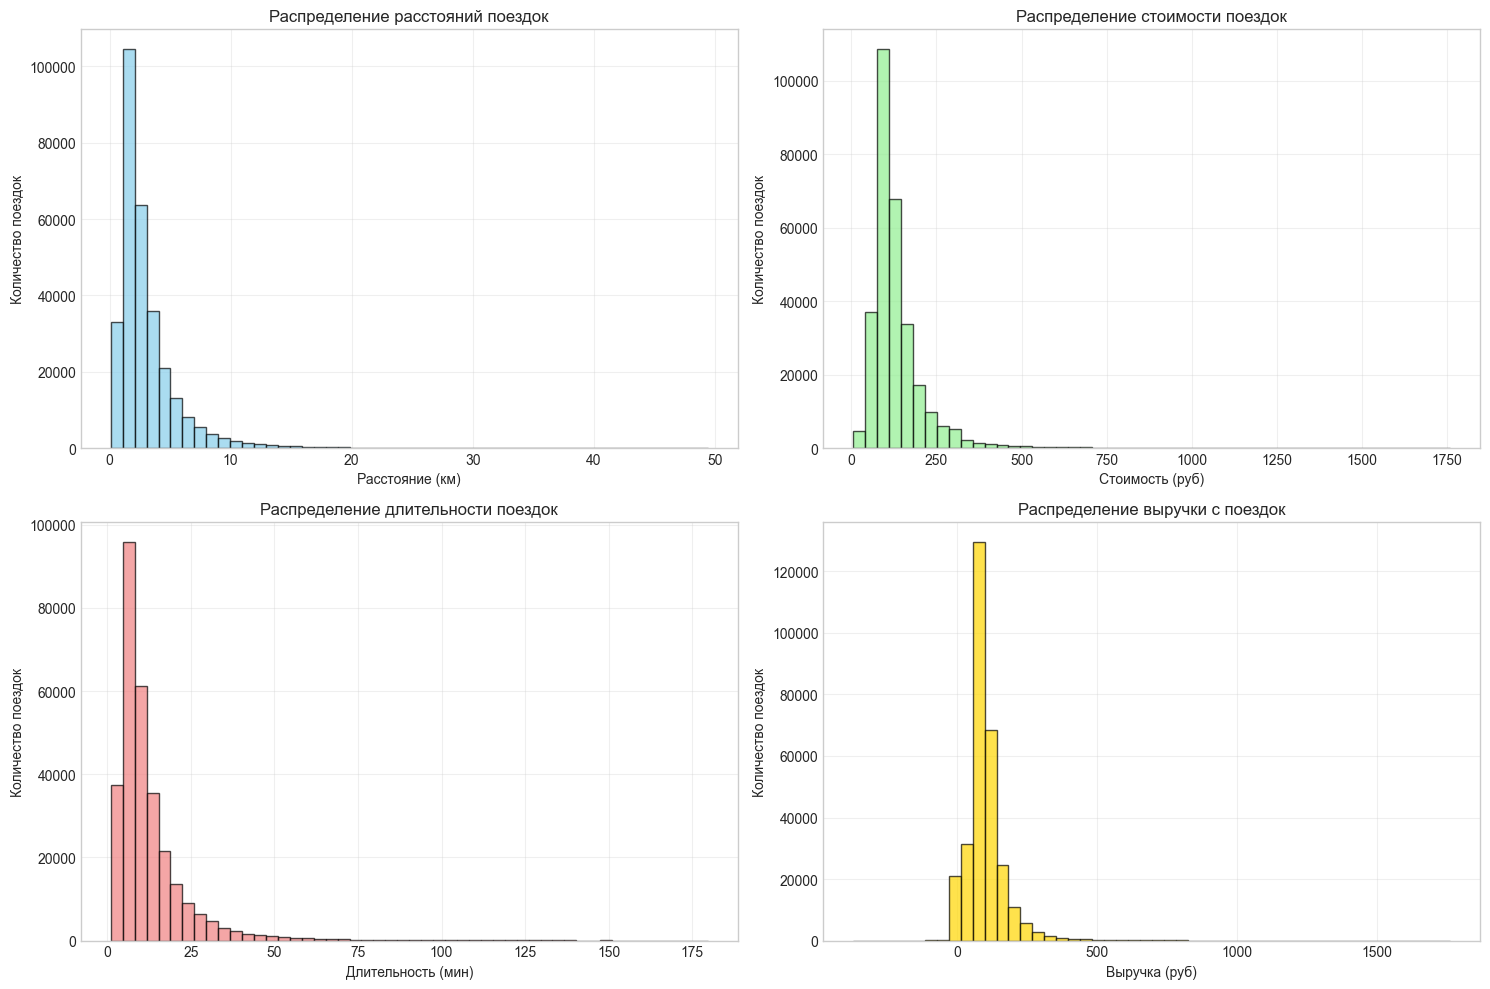

In [6]:
print(" ОСНОВНЫЕ СТАТИСТИКИ ПОЕЗДОК (после очистки):")
stats_clean = df_clean[['distance_km', 'nominal_price_rub_amt', 'trip_duration_min', 'revenue']].describe()
display(stats_clean)

# Визуализация распределений
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение расстояний
axes[0,0].hist(df_clean['distance_km'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Расстояние (км)')
axes[0,0].set_ylabel('Количество поездок')
axes[0,0].set_title('Распределение расстояний поездок')
axes[0,0].grid(alpha=0.3)

# Распределение стоимости
axes[0,1].hist(df_clean['nominal_price_rub_amt'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_xlabel('Стоимость (руб)')
axes[0,1].set_ylabel('Количество поездок')
axes[0,1].set_title('Распределение стоимости поездок')
axes[0,1].grid(alpha=0.3)

# Распределение длительности
axes[1,0].hist(df_clean['trip_duration_min'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].set_xlabel('Длительность (мин)')
axes[1,0].set_ylabel('Количество поездок')
axes[1,0].set_title('Распределение длительности поездок')
axes[1,0].grid(alpha=0.3)

# Распределение выручки
axes[1,1].hist(df_clean['revenue'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_xlabel('Выручка (руб)')
axes[1,1].set_ylabel('Количество поездок')
axes[1,1].set_title('Распределение выручки с поездок')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Выводы:** 
- Типичная поездка длится ~9 минут и покрывает 2,2 км со средним чеком 134 руб.  
- Распределение стоимости имеет длинный хвост — встречаются отдельные дорогие поездки.  
- Большинство аренд короткие (<30 мин), что типично для самокатов и коротких городских поездок.


## 4. Временные паттерны и сезонность

 АНАЛИЗ АКТИВНОСТИ ПО ЧАСАМ СУТОК:


,количество_поездок,ср_стоимость,ср_дистанция,ср_длительность
trip_hour,,,,
0,1980,135.340,3.420,13.730
1,2638,111.040,3.040,11.530
2,4009,101.930,2.730,10.320
3,7917,104.280,2.640,9.960
4,13543,107.590,2.610,9.510
5,19005,112.240,2.650,9.600
6,15206,116.620,2.730,10.310
7,12314,118.700,2.760,11.060
8,11993,127.510,2.910,12.410



 РАСПРЕДЕЛЕНИЕ ПО ВРЕМЕННЫМ ПЕРИОДАМ СУТОК:


,количество_поездок,ср_стоимость,ср_дистанция,ср_длительность,ср_выручка,доля_%
time_period,,,,,,
Утро,101080,124.410,2.870,11.680,91.320,33.780
День,101690,143.040,3.190,13.310,103.050,33.980
Вечер,64009,144.120,3.250,13.300,105.870,21.390
Ночь,32459,111.060,2.800,10.510,85.480,10.850



 АНАЛИЗ АКТИВНОСТИ ПО ДНЯМ НЕДЕЛИ:


,количество_поездок,ср_стоимость,ср_выручка
trip_weekday_name,,,
Monday,42207,127.760,93.770
Tuesday,43730,128.670,95.820
Wednesday,44895,128.630,95.940
Thursday,45366,128.210,94.920
Friday,47433,130.860,96.660
Saturday,40078,146.870,104.530
Sunday,35529,147.690,104.870



 СЕЗОННЫЙ АНАЛИЗ ПО МЕСЯЦАМ:


,количество_поездок,ср_стоимость,ср_выручка,ср_дистанция,доля_%
trip_month_name,,,,,
April,32,110.240,101.190,3.220,0.010
May,3205,145.920,129.530,2.690,1.070
June,29741,125.130,108.220,2.530,9.940
July,58603,129.790,107.650,2.880,19.580
August,83134,136.280,94.630,3.380,27.780
September,93126,137.750,92.050,3.300,31.120
October,31397,127.220,91.640,2.280,10.490


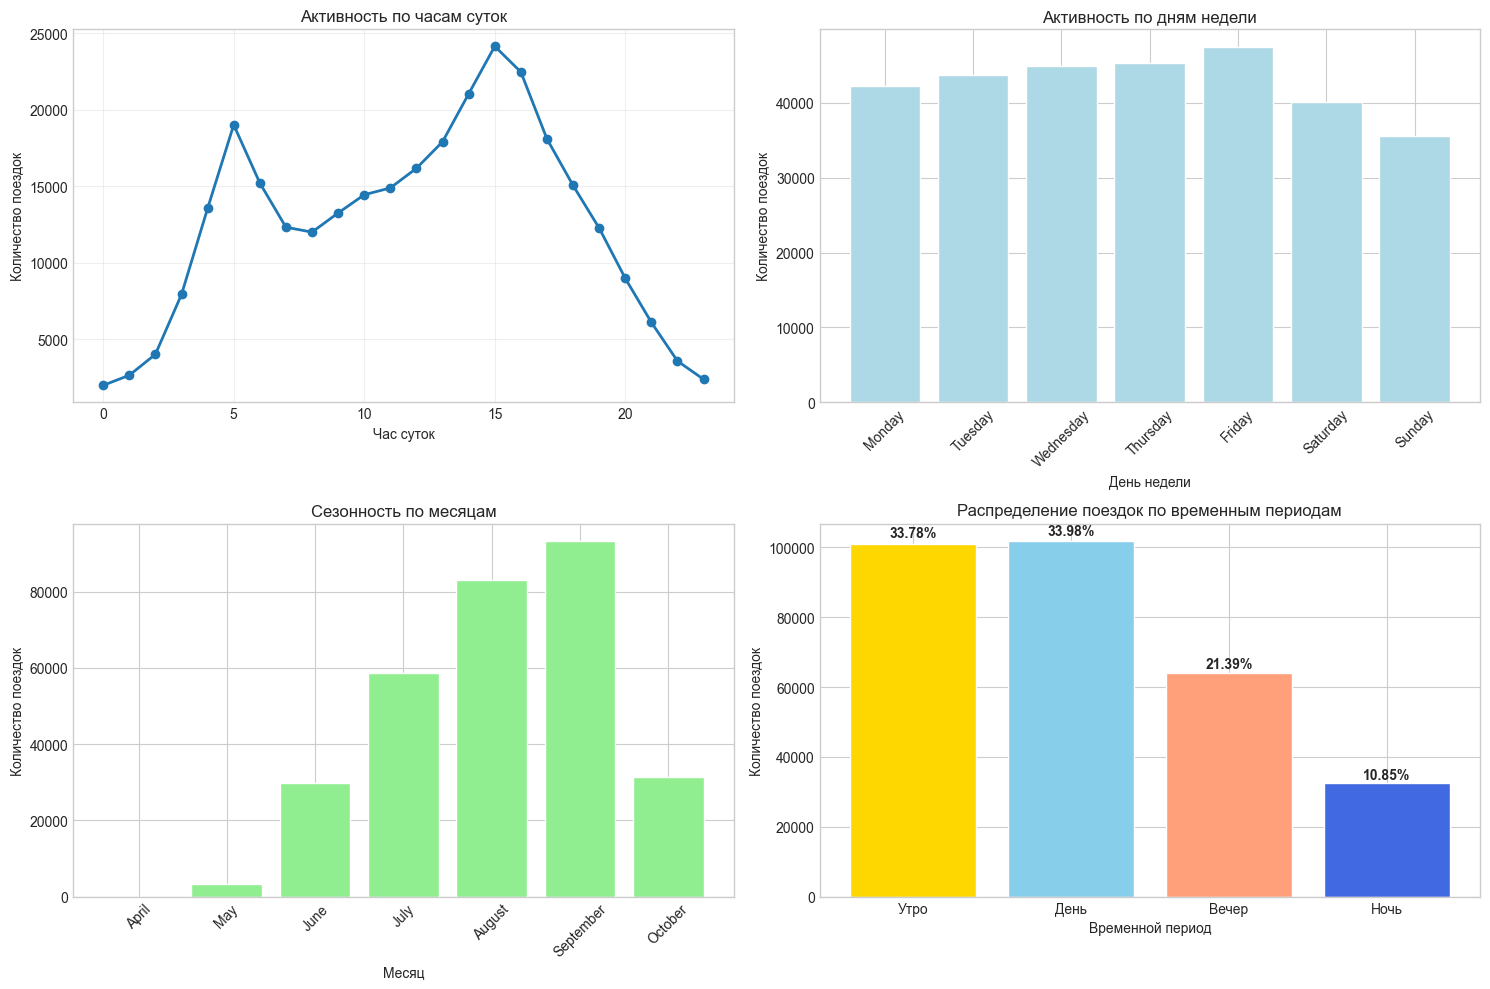

In [23]:
# Преобразуем дату начала и конца поездки в datetime с указанием UTC
df_clean['book_start_dttm'] = pd.to_datetime(df_clean['book_start_dttm'], utc=True)
df_clean['book_end_dttm'] = pd.to_datetime(df_clean['book_end_dttm'], utc=True)

# Функция для перевода в локальное время по часовому поясу
def to_local_time(row):
    try:
        tz = pytz.timezone(row['book_time_zone_cd'])
        return row['book_start_dttm'].astimezone(tz)
    except Exception:
        # Если timezone отсутствует или некорректен — оставляем UTC
        return row['book_start_dttm']

# Создаём колонку с локальным временем начала поездки
df_clean['local_book_start_dttm'] = df_clean.apply(to_local_time, axis=1)

# Создаём временные признаки на основе локального времени
df_clean['trip_hour'] = df_clean['local_book_start_dttm'].dt.hour
df_clean['trip_weekday_name'] = df_clean['local_book_start_dttm'].dt.day_name()
df_clean['trip_month_name'] = df_clean['local_book_start_dttm'].dt.month_name()

# Определяем временные периоды
def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 17:
        return 'День'
    elif 17 <= hour < 23:
        return 'Вечер'
    else:
        return 'Ночь'

df_clean['time_period'] = df_clean['trip_hour'].apply(get_time_period)

# Дата и длительность поездки (в минутах)
df_clean['trip_date'] = df_clean['local_book_start_dttm'].dt.date
df_clean['trip_duration_min'] = (
    (df_clean['book_end_dttm'] - df_clean['book_start_dttm']).dt.total_seconds() / 60
).round(1)

#  АНАЛИЗ ПО ВРЕМЕНИ 

# Анализ по часам суток
print(" АНАЛИЗ АКТИВНОСТИ ПО ЧАСАМ СУТОК:")
hourly_analysis = df_clean.groupby('trip_hour').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'distance_km': 'mean',
    'trip_duration_min': 'mean'
}).round(2)

hourly_analysis.columns = ['количество_поездок', 'ср_стоимость', 'ср_дистанция', 'ср_длительность']
display(hourly_analysis.head(24))

# Анализ по временным периодам
print("\n РАСПРЕДЕЛЕНИЕ ПО ВРЕМЕННЫМ ПЕРИОДАМ СУТОК:")
time_period_order = ['Утро', 'День', 'Вечер', 'Ночь']
time_period_analysis = df_clean.groupby('time_period').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'distance_km': 'mean',
    'trip_duration_min': 'mean',
    'revenue': 'mean'
}).round(2).reindex(time_period_order)

time_period_analysis.columns = ['количество_поездок', 'ср_стоимость', 'ср_дистанция', 'ср_длительность', 'ср_выручка']
time_period_analysis['доля_%'] = (time_period_analysis['количество_поездок'] / len(df_clean) * 100).round(2)
display(time_period_analysis)

# Анализ по дням недели
print("\n АНАЛИЗ АКТИВНОСТИ ПО ДНЯМ НЕДЕЛИ:")
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_analysis = df_clean.groupby('trip_weekday_name').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'revenue': 'mean'
}).round(2).reindex(weekday_order)

weekday_analysis.columns = ['количество_поездок', 'ср_стоимость', 'ср_выручка']
display(weekday_analysis)

# Сезонный анализ по месяцам
print("\n СЕЗОННЫЙ АНАЛИЗ ПО МЕСЯЦАМ:")
month_order = ['April', 'May', 'June', 'July', 'August', 'September', 'October']
monthly_analysis = df_clean.groupby('trip_month_name').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'revenue': 'mean',
    'distance_km': 'mean'
}).round(2).reindex(month_order)

monthly_analysis.columns = ['количество_поездок', 'ср_стоимость', 'ср_выручка', 'ср_дистанция']
monthly_analysis['доля_%'] = (monthly_analysis['количество_поездок'] / len(df_clean) * 100).round(2)
display(monthly_analysis)

#  ВИЗУАЛИЗАЦИИ 

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Активность по часам суток
axes[0,0].plot(hourly_analysis.index, hourly_analysis['количество_поездок'], marker='o', linewidth=2)
axes[0,0].set_xlabel('Час суток')
axes[0,0].set_ylabel('Количество поездок')
axes[0,0].set_title('Активность по часам суток')
axes[0,0].grid(True, alpha=0.3)

# Активность по дням недели
axes[0,1].bar(weekday_analysis.index, weekday_analysis['количество_поездок'], color='lightblue')
axes[0,1].set_xlabel('День недели')
axes[0,1].set_ylabel('Количество поездок')
axes[0,1].set_title('Активность по дням недели')
axes[0,1].tick_params(axis='x', rotation=45)

# Сезонность по месяцам
axes[1,0].bar(monthly_analysis.index, monthly_analysis['количество_поездок'], color='lightgreen')
axes[1,0].set_xlabel('Месяц')
axes[1,0].set_ylabel('Количество поездок')
axes[1,0].set_title('Сезонность по месяцам')
axes[1,0].tick_params(axis='x', rotation=45)

# Распределение по временным периодам
colors = ['#FFD700', '#87CEEB', '#FFA07A', '#4169E1']  
bars = axes[1,1].bar(time_period_analysis.index, time_period_analysis['количество_поездок'], color=colors)
axes[1,1].set_xlabel('Временной период')
axes[1,1].set_ylabel('Количество поездок')
axes[1,1].set_title('Распределение поездок по временным периодам')

# Добавляем подписи с долями на столбцах
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = time_period_analysis['доля_%'].iloc[i]
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                  f'{percentage}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Выводы:**
- Средняя длительность поездки: 11.4 минут
- Вечерние часы и выходные - пик использования сервиса
- Летние месяцы демонстрируют наибольшую активность
- Распределение поездок соответствует смешанному использованию (работа + развлечения)
- Пиковая активность наблюдается в 15:00 — в этот час совершается наибольшее количество поездок (30,406).
- Наиболее активный день недели: Пятница, наименее активный — Воскресенье.
- Сезонный пик поездок — в Сентябре, минимум — в Апреле.
- В будние дни совершается примерно 74.2% всех поездок, в выходные — 25.8%

## 5. Анализ пользователей и их поведения

👤 СТАТИСТИКА ПОЛЬЗОВАТЕЛЕЙ:
  • Уникальных пользователей: 53,329
  • Среднее количество поездок на пользователя: 5.61
  • Медианное количество поездок: 2
  • Пользователей с 1 поездкой: 22620 (42.4%)
  • Возвращающихся пользователей: 30709 (57.6%)

💎 LTV (LIFETIME VALUE):
  • Средний LTV: 549 руб.
  • Медианный LTV: 178 руб.
  • Общая выручка от пользователей: 29,261,413 руб.

🏆 ТОП-10 САМЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ:


,total_trips,total_spent,total_distance,total_duration
party_rk,,,,
910211081,301,44891 руб,1061.9 км,4962.7 мин
386134592,296,49770 руб,1600.4 км,6675.3 мин
759042976,289,53099 руб,2101.0 км,6610.7 мин
391309281,285,29220 руб,664.6 км,2129.8 мин
636557947,279,33148 руб,990.6 км,3866.0 мин
1014406182,276,29678 руб,1092.4 км,3042.0 мин
798060910,229,18005 руб,487.5 км,1817.3 мин
231464761,200,24455 руб,413.2 км,1653.2 мин
604949025,192,23274 руб,597.4 км,1990.2 мин



📊 СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ:


,Кол-во пользователей,Ср. поездок,Ср. выручка,Сум. выручка,Ср. расстояние
total_trips,,,,,
Однократные,22620,1.000,67.900,1535830.080,4.180
Редкие (2-3),13701,2.350,229.010,3137642.960,7.940
Активные (4-10),10468,6.020,634.510,6642098.490,18.200
Супер-активные (10+),6540,27.740,2744.010,17945841.110,79.370


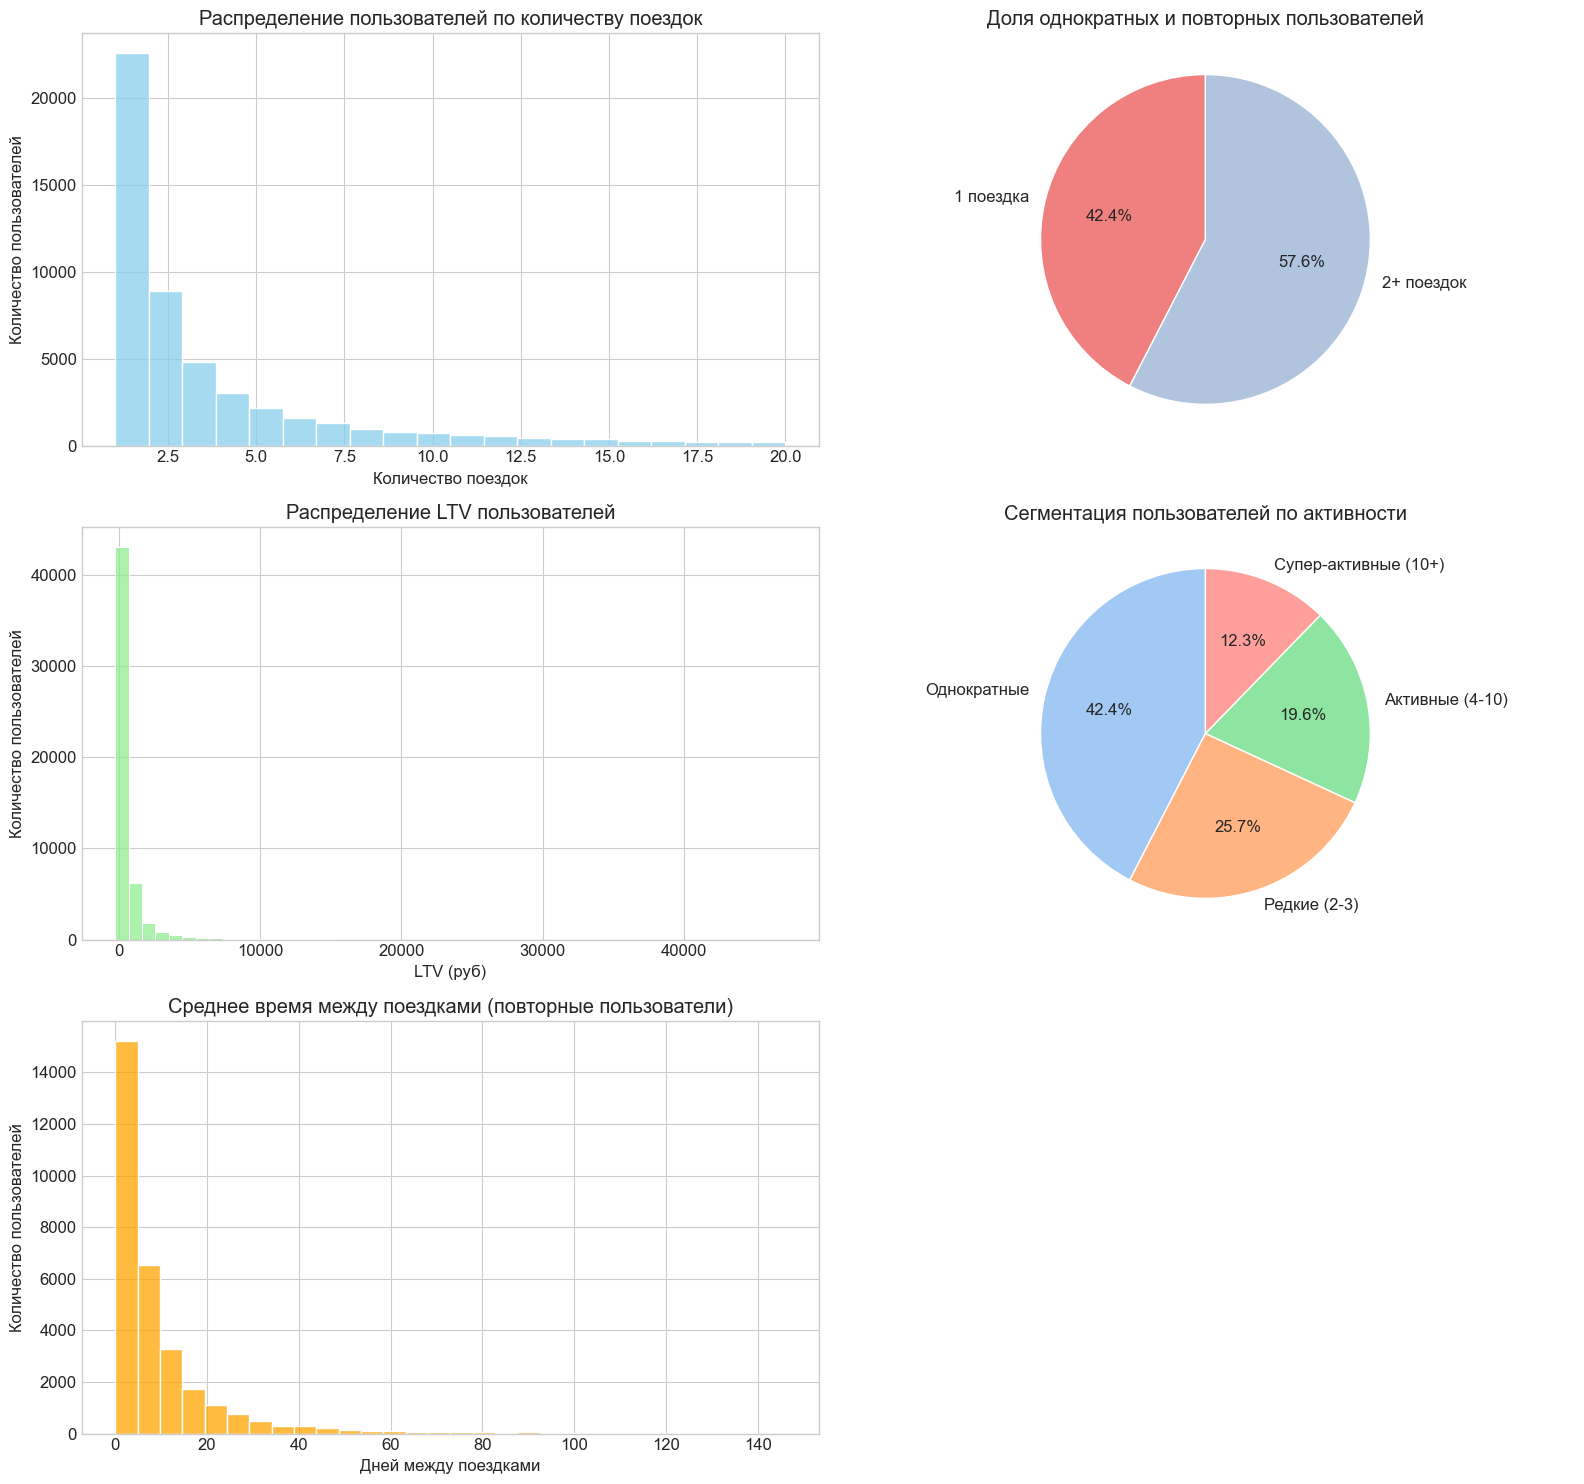

In [44]:
# Базовая статистика пользователей
user_activity = df_clean.groupby('party_rk').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'sum',
    'revenue': 'sum',
    'distance_km': 'sum',
    'trip_duration_min': 'sum',
    'book_start_dttm': ['min', 'max']
}).round(2)

user_activity.columns = ['total_trips', 'total_spent', 'total_revenue', 'total_distance', 
                        'total_duration', 'first_trip', 'last_trip']

# Анализ удержания
user_activity['days_active'] = (user_activity['last_trip'] - user_activity['first_trip']).dt.days
user_activity['avg_days_between'] = user_activity.apply(
    lambda x: x['days_active'] / (x['total_trips'] - 1) if x['total_trips'] > 1 else 0, 
    axis=1
)

print("👤 СТАТИСТИКА ПОЛЬЗОВАТЕЛЕЙ:")
print(f"  • Уникальных пользователей: {len(user_activity):,}")
print(f"  • Среднее количество поездок на пользователя: {user_activity['total_trips'].mean():.2f}")
print(f"  • Медианное количество поездок: {user_activity['total_trips'].median():.0f}")

single_trip_users = (user_activity['total_trips'] == 1).sum()
multiple_trip_users = (user_activity['total_trips'] > 1).sum()
print(f"  • Пользователей с 1 поездкой: {single_trip_users} ({single_trip_users/len(user_activity)*100:.1f}%)")
print(f"  • Возвращающихся пользователей: {multiple_trip_users} ({multiple_trip_users/len(user_activity)*100:.1f}%)")

print(f"\n💎 LTV (LIFETIME VALUE):")
print(f"  • Средний LTV: {user_activity['total_revenue'].mean():.0f} руб.")
print(f"  • Медианный LTV: {user_activity['total_revenue'].median():.0f} руб.")
print(f"  • Общая выручка от пользователей: {user_activity['total_revenue'].sum():,.0f} руб.")

# ТОП-10 САМЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ
print("\n🏆 ТОП-10 САМЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ:")
top_users = user_activity.nlargest(10, 'total_trips')[['total_trips', 'total_spent', 'total_distance', 'total_duration']]
display(top_users.style.format({
    'total_trips': '{:.0f}',
    'total_spent': '{:.0f} руб',
    'total_distance': '{:.1f} км',
    'total_duration': '{:.1f} мин'
}))

# Сегментация пользователей по активности
user_segments = pd.cut(user_activity['total_trips'], 
                      bins=[0, 1, 3, 10, float('inf')],
                      labels=['Однократные', 'Редкие (2-3)', 'Активные (4-10)', 'Супер-активные (10+)'])

print(f"\n📊 СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ:")
segment_stats = user_activity.groupby(user_segments, observed=False).agg({
    'total_trips': ['count', 'mean'],
    'total_revenue': ['mean', 'sum'],
    'total_distance': 'mean'
}).round(2)

segment_stats.columns = ['Кол-во пользователей', 'Ср. поездок', 'Ср. выручка', 'Сум. выручка', 'Ср. расстояние']
display(segment_stats)

# Визуализация пользовательской активности
# Стиль графиков
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 16
})

fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# Распределение по количеству поездок
user_trip_counts = user_activity['total_trips']
sns.histplot(user_trip_counts[user_trip_counts <= 20], bins=20, ax=axes[0,0], color='skyblue')
axes[0,0].set_xlabel('Количество поездок')
axes[0,0].set_ylabel('Количество пользователей')
axes[0,0].set_title('Распределение пользователей по количеству поездок')

# Доля однократных vs повторных
axes[0,1].pie([single_trip_users, multiple_trip_users], 
              labels=['1 поездка', '2+ поездок'], 
              autopct='%1.1f%%', 
              colors=['lightcoral', 'lightsteelblue'], 
              startangle=90, 
              wedgeprops={'edgecolor':'white'})
axes[0,1].set_title('Доля однократных и повторных пользователей')

# Распределение LTV
sns.histplot(user_activity['total_revenue'], bins=50, ax=axes[1,0], color='lightgreen')
axes[1,0].set_xlabel('LTV (руб)')
axes[1,0].set_ylabel('Количество пользователей')
axes[1,0].set_title('Распределение LTV пользователей')

# Сегментация пользователей по активности
segment_counts = user_segments.value_counts().sort_index()
axes[1,1].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
              startangle=90, colors=sns.color_palette('pastel'))
axes[1,1].set_title('Сегментация пользователей по активности')

# Среднее время между поездками (для повторных)
if multiple_trip_users > 0:
    sns.histplot(user_activity[user_activity['total_trips'] > 1]['avg_days_between'], 
                 bins=30, ax=axes[2,0], color='orange')
    axes[2,0].set_title('Среднее время между поездками (повторные пользователи)')
    axes[2,0].set_xlabel('Дней между поездками')
    axes[2,0].set_ylabel('Количество пользователей')
else:
    axes[2,0].text(0.5, 0.5, 'Нет данных о повторных пользователях', 
                    ha='center', va='center', transform=axes[2,0].transAxes)
    axes[2,0].set_title('Среднее время между поездками')

# Пустая ячейка
axes[2,1].axis('off')

plt.tight_layout()
plt.show()

**Выводы:**
- Большинство пользователей (42.4%) совершают только одну поездку, что указывает на проблему с удержанием клиентов.
- При этом существует группа лояльных пользователей (31.9%), которая генерирует 84.0% всей выручки.

## 6. Демографический анализ


ПРОПУСКИ ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ:


,"Доля пропусков, %"
education_level_cd,51.960
marital_status_cd,44.960
lvn_state_nm,8.810
gender_cd,0.630
age,0.000


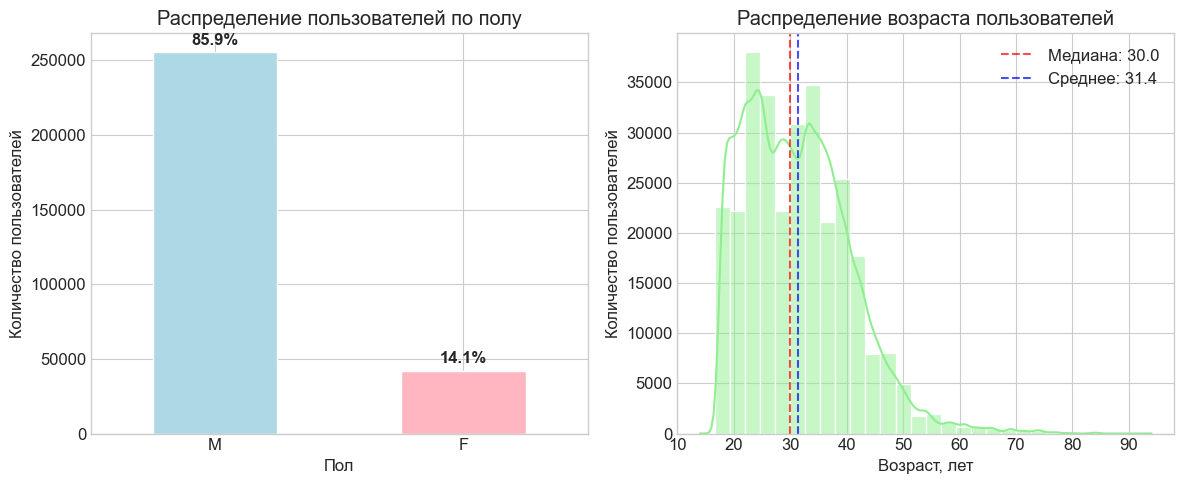

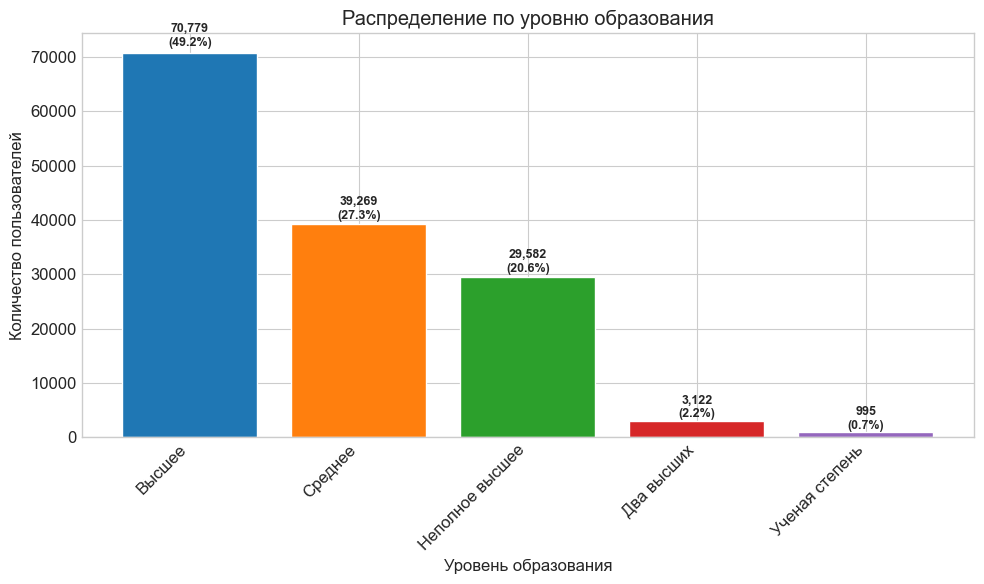

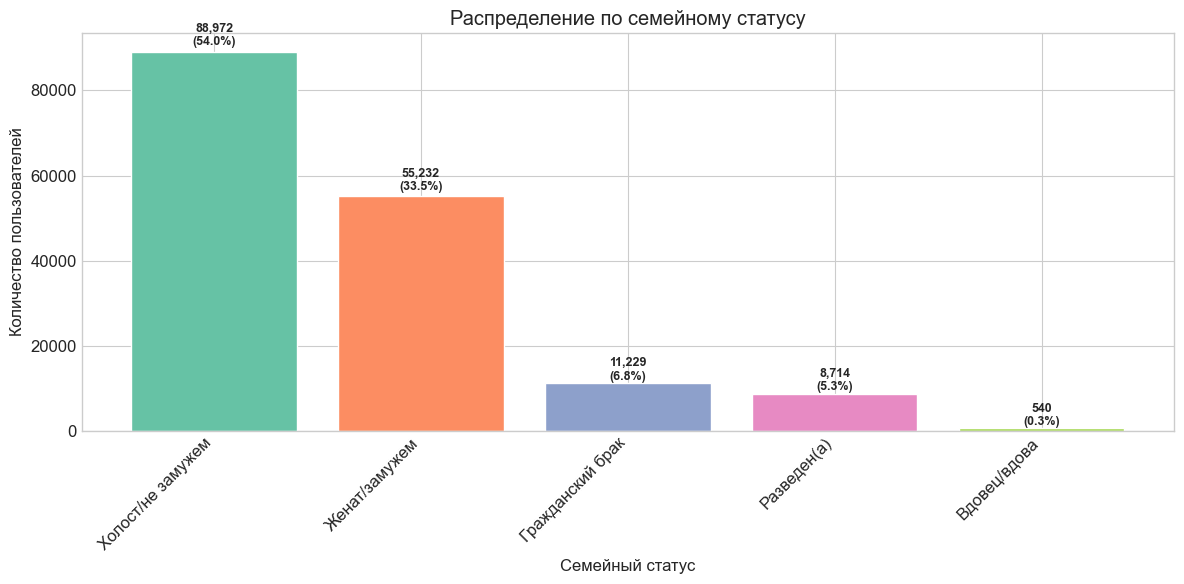

In [53]:
# Проверим долю пропусков
demo_cols = ['gender_cd', 'age', 'education_level_cd', 'lvn_state_nm', 'marital_status_cd']
print("\nПРОПУСКИ ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ:")
missing_stats = df_clean[demo_cols].isnull().mean().sort_values(ascending=False) * 100
missing_stats_df = pd.DataFrame({'Доля пропусков, %': missing_stats.round(2)})
display(missing_stats_df)

# Анализ только на данных без пропусков для демографии
df_demo = df_clean.dropna(subset=['gender_cd', 'age'])

# 1. Пол пользователей
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
gender_counts = df_demo['gender_cd'].value_counts()
colors = ['lightblue', 'lightpink']
gender_counts.plot(kind='bar', color=colors)
plt.title('Распределение пользователей по полу')
plt.xlabel('Пол')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)

# Добавляем проценты на график
total_gender = gender_counts.sum()
for i, count in enumerate(gender_counts):
    plt.text(i, count + total_gender * 0.01, f'{count/total_gender*100:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 2. Возраст
plt.subplot(1,2,2)
sns.histplot(df_demo['age'], bins=30, kde=True, color='lightgreen')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей')

# Добавляем линии для медианы и среднего
median_age = df_demo['age'].median()
mean_age = df_demo['age'].mean()
plt.axvline(median_age, color='red', linestyle='--', alpha=0.7, label=f'Медиана: {median_age:.1f}')
plt.axvline(mean_age, color='blue', linestyle='--', alpha=0.7, label=f'Среднее: {mean_age:.1f}')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Образование (если данные есть)
if 'education_level_cd' in df_clean.columns and df_clean['education_level_cd'].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    
    edu_data = df_clean['education_level_cd'].dropna()
    
    # Расшифровка кодов образования для читаемости
    edu_mapping = {
        'SCH': 'Среднее',
        'GRD': 'Высшее', 
        'UGR': 'Неполное высшее',
        'PGR': 'Два высших',
        'ACD': 'Ученая степень'
    }
    edu_decoded = edu_data.map(edu_mapping)
    
    edu_counts = edu_decoded.value_counts()
    
    # Вертикальная столбчатая диаграмма
    colors_edu = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = plt.bar(range(len(edu_counts)), edu_counts.values, color=colors_edu)
    plt.xticks(range(len(edu_counts)), edu_counts.index, rotation=45, ha='right')
    plt.title('Распределение по уровню образования')
    plt.xlabel('Уровень образования')
    plt.ylabel('Количество пользователей')
    
    # Добавляем значения и проценты на вертикальные столбцы
    total_edu = edu_counts.sum()
    for i, (count, bar) in enumerate(zip(edu_counts.values, bars)):
        height = bar.get_height()
        percentage = (count / total_edu) * 100
        plt.text(i, height + height * 0.01, f'{count:,}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# 4. Семейный статус (если данные есть)
if 'marital_status_cd' in df_clean.columns and df_clean['marital_status_cd'].notna().sum() > 0:
    plt.figure(figsize=(12, 6))
    marital_data = df_clean['marital_status_cd'].dropna()
    
    # Расшифровка кодов семейного статуса
    marital_mapping = {
        'UNM': 'Холост/не замужем',
        'MAR': 'Женат/замужем', 
        'IMR': 'Незарегистрированный брак',
        'OMR': 'Зарегистрированный брак',
        'CIV': 'Гражданский брак',
        'DIV': 'Разведен(а)',
        'WID': 'Вдовец/вдова',
        'FAL': 'Никогда не состоял(а)',
        'DLW': 'Не проживает с супругом(ой)'
    }
    marital_decoded = marital_data.map(marital_mapping)
    
    marital_counts = marital_decoded.value_counts()
 
    colors_marital = sns.color_palette("Set2", len(marital_counts))
    bars = plt.bar(range(len(marital_counts)), marital_counts.values, color=colors_marital)
    plt.xticks(range(len(marital_counts)), marital_counts.index, rotation=45, ha='right')
    plt.title('Распределение по семейному статусу')
    plt.xlabel('Семейный статус')
    plt.ylabel('Количество пользователей')
    
    # Добавляем значения и проценты на столбцы
    total_marital = marital_counts.sum()
    for i, (count, bar) in enumerate(zip(marital_counts.values, bars)):
        height = bar.get_height()
        percentage = (count / total_marital) * 100
        plt.text(i, height + height * 0.01, f'{count:,}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 7. Анализ продукта и тарифов

 АНАЛИЗ МОДЕЛЕЙ САМОКАТОВ:


,количество_поездок,ср_стоимость,ср_выручка,ср_дистанция,ср_длительность,доля_рынка_%,общая_выручка
transport_model,,,,,,,
SL,182104,136.450,99.990,3.130,11.920,60.860,18208578.960
Max,53810,135.580,98.740,3.290,13.590,17.980,5313199.400
E,51307,117.420,87.340,2.560,12.680,17.150,4481153.380
Urban E-Bike,3510,137.110,95.770,3.190,11.880,1.170,336152.700
ES400,3111,142.740,99.280,2.860,14.840,1.040,308860.080
ES200,2112,149.720,109.200,2.590,14.230,0.710,230630.400
ES100,1753,155.500,104.910,2.640,16.570,0.590,183907.230
MK,779,156.320,117.810,2.820,16.500,0.260,91773.990
ES-08S,508,200.030,152.790,3.440,19.980,0.170,77617.320



 АНАЛИЗ ТАРИФОВ:


,количество_поездок,ср_стоимость_активации,ср_стоимость,ср_дистанция,ср_длительность
minute_cost,,,,,
7.490,39232,47.750,146.020,3.450,12.710
6.990,32740,45.740,130.750,2.870,11.730
5.990,32631,32.260,107.840,2.690,12.190
4.990,32441,37.580,113.070,3.460,14.720
6.490,31546,31.870,115.660,2.950,12.490
...,...,...,...,...,...
5.130,1,30.000,153.120,2.510,24.000
5.430,1,30.000,138.600,4.530,19.800
10.700,1,50.000,125.530,2.180,6.600


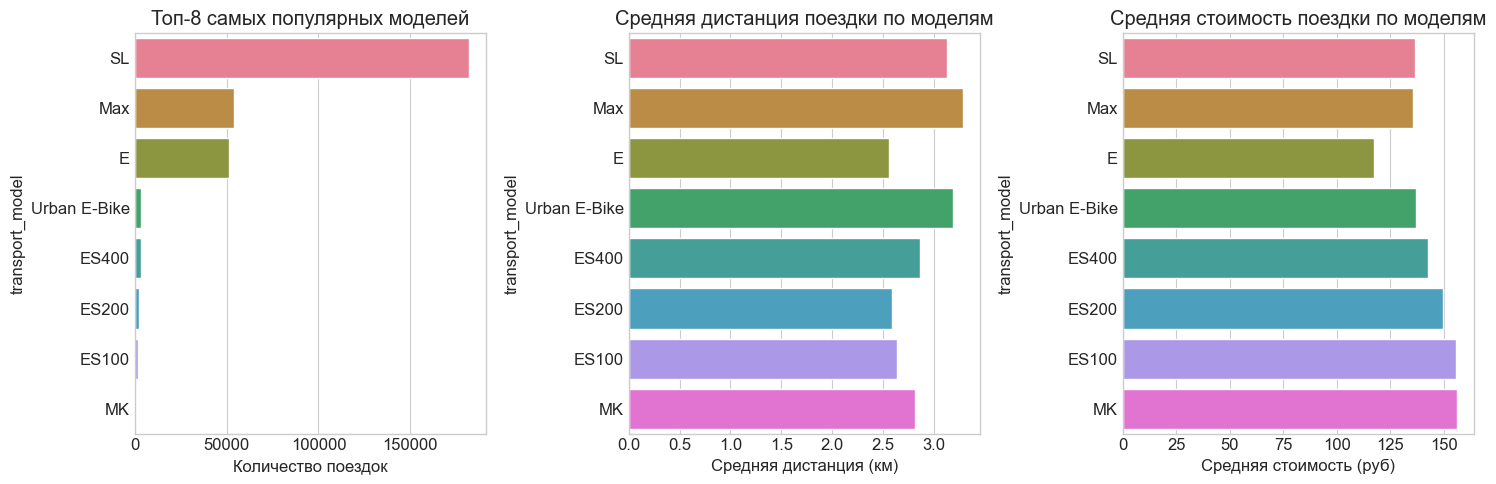

In [45]:
# Анализ моделей самокатов
print(" АНАЛИЗ МОДЕЛЕЙ САМОКАТОВ:")
scooter_analysis = df_clean.groupby('transport_model').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'revenue': 'mean',
    'distance_km': 'mean',
    'trip_duration_min': 'mean'
}).round(2).sort_values('order_rk', ascending=False)

scooter_analysis.columns = ['количество_поездок', 'ср_стоимость', 'ср_выручка', 'ср_дистанция', 'ср_длительность']
scooter_analysis['доля_рынка_%'] = (scooter_analysis['количество_поездок'] / len(df_clean) * 100).round(2)
scooter_analysis['общая_выручка'] = scooter_analysis['количество_поездок'] * scooter_analysis['ср_выручка']

display(scooter_analysis.head(10))

# Анализ тарифов
print("\n АНАЛИЗ ТАРИФОВ:")
tariff_analysis = df_clean.groupby('minute_cost').agg({
    'order_rk': 'count',
    'activation_cost': 'mean',
    'nominal_price_rub_amt': 'mean',
    'distance_km': 'mean',
    'trip_duration_min': 'mean'
}).round(2).sort_values('order_rk', ascending=False)

tariff_analysis.columns = ['количество_поездок', 'ср_стоимость_активации', 'ср_стоимость', 'ср_дистанция', 'ср_длительность']
display(tariff_analysis)

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
top_scooters = scooter_analysis.head(8)
colors_scooters = sns.color_palette("husl", len(top_scooters))
sns.barplot(x=top_scooters['количество_поездок'], y=top_scooters.index,
            hue=top_scooters.index, palette=colors_scooters, legend=False)
plt.title('Топ-8 самых популярных моделей')
plt.xlabel('Количество поездок')

plt.subplot(1, 3, 2)
# Средняя дистанция по моделям
sns.barplot(x=top_scooters['ср_дистанция'], y=top_scooters.index,
            hue=top_scooters.index, palette=colors_scooters, legend=False)
plt.title('Средняя дистанция поездки по моделям')
plt.xlabel('Средняя дистанция (км)')

plt.subplot(1, 3, 3)
# Средняя стоимость по моделям
sns.barplot(x=top_scooters['ср_стоимость'], y=top_scooters.index,
            hue=top_scooters.index, palette=colors_scooters, legend=False)
plt.title('Средняя стоимость поездки по моделям')
plt.xlabel('Средняя стоимость (руб)')

plt.tight_layout()
plt.show()

**Выводы:**
- SL лидирует на рынке с долей 60,9% поездок, при этом наиболее доходная модель — ES-08S.
- На платформе представлено 541 тариф, при этом самый популярный — 7,49 руб/мин.

## 8. Географический анализ

🗺️ АНАЛИЗ РЕГИОНАЛЬНОЙ АКТИВНОСТИ:
Всего регионов: 201


,количество_поездок,ср_стоимость,ср_выручка,ср_дистанция,ср_длительность,доля_%
lvn_state_nm,,,,,,
Г МОСКВА,61318,139.230,104.330,2.780,10.950,20.490
Г САНКТ-ПЕТЕРБУРГ,31213,131.840,97.450,3.080,11.430,10.430
МОСКОВСКАЯ ОБЛ,28610,136.160,100.620,2.810,11.320,9.560
СВЕРДЛОВСКАЯ ОБЛ,23894,109.110,83.300,2.570,11.980,7.980
КРАСНОДАРСКИЙ КРАЙ,13469,130.790,99.830,3.660,13.230,4.500
РЕСП ТАТАРСТАН,8084,118.010,82.370,3.050,13.390,2.700
РЕСП БАШКОРТОСТАН,6197,130.320,97.020,2.790,13.990,2.070
НОВОСИБИРСКАЯ ОБЛ,5431,107.660,76.990,2.500,12.670,1.810
НИЖЕГОРОДСКАЯ ОБЛ,5401,138.730,102.700,2.910,13.730,1.800


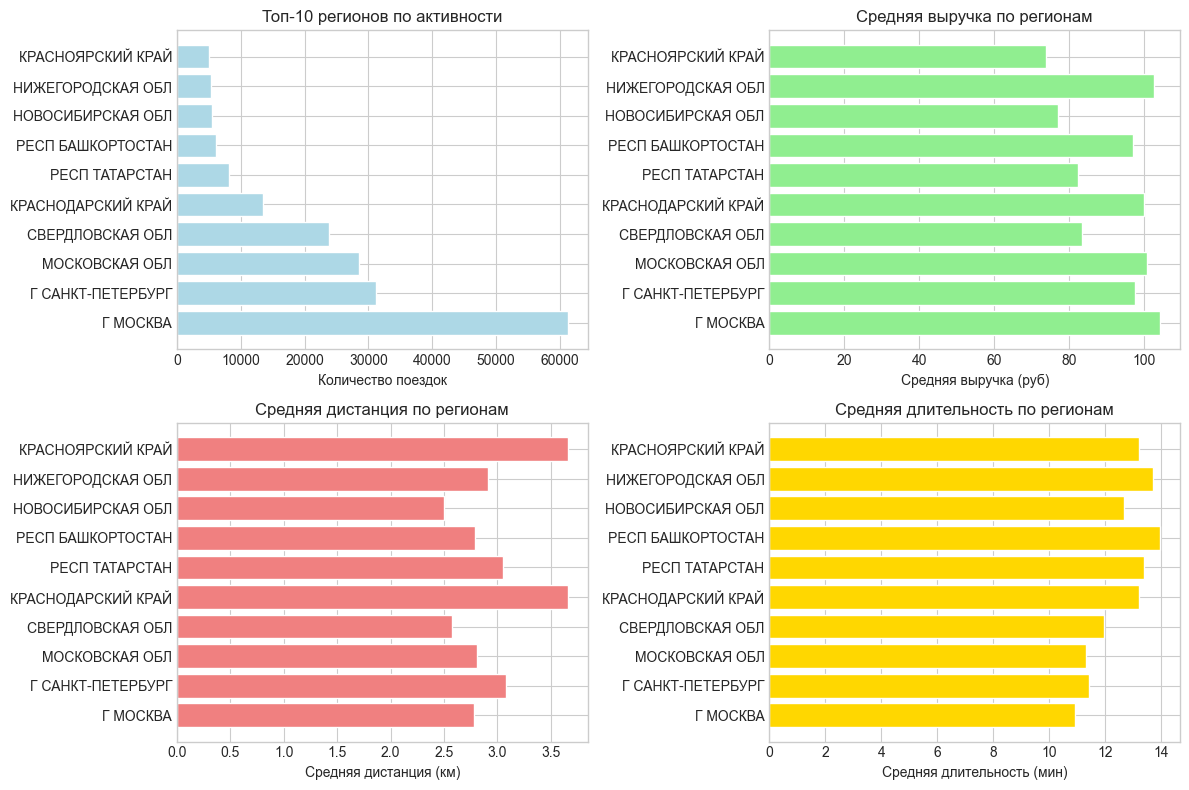

In [38]:
if 'lvn_state_nm' in df_clean.columns and df_clean['lvn_state_nm'].notna().sum() > 0:
    print("🗺️ АНАЛИЗ РЕГИОНАЛЬНОЙ АКТИВНОСТИ:")
    
    regional_analysis = df_clean.groupby('lvn_state_nm').agg({
        'order_rk': 'count',
        'nominal_price_rub_amt': 'mean',
        'revenue': 'mean',
        'distance_km': 'mean',
        'trip_duration_min': 'mean'
    }).round(2).sort_values('order_rk', ascending=False)
    
    regional_analysis.columns = ['количество_поездок', 'ср_стоимость', 'ср_выручка', 'ср_дистанция', 'ср_длительность']
    regional_analysis['доля_%'] = (regional_analysis['количество_поездок'] / len(df_clean) * 100).round(2)
    
    print(f"Всего регионов: {regional_analysis.shape[0]}")
    display(regional_analysis.head(15))
    
    # Визуализация топ регионов
    plt.figure(figsize=(12, 8))
    top_regions = regional_analysis.head(10)
    
    plt.subplot(2, 2, 1)
    plt.barh(top_regions.index, top_regions['количество_поездок'], color='lightblue')
    plt.xlabel('Количество поездок')
    plt.title('Топ-10 регионов по активности')
    
    plt.subplot(2, 2, 2)
    plt.barh(top_regions.index, top_regions['ср_выручка'], color='lightgreen')
    plt.xlabel('Средняя выручка (руб)')
    plt.title('Средняя выручка по регионам')
    
    plt.subplot(2, 2, 3)
    plt.barh(top_regions.index, top_regions['ср_дистанция'], color='lightcoral')
    plt.xlabel('Средняя дистанция (км)')
    plt.title('Средняя дистанция по регионам')
    plt.subplot(2, 2, 4)
    plt.barh(top_regions.index, top_regions['ср_длительность'], color='gold')
    plt.xlabel('Средняя длительность (мин)')
    plt.title('Средняя длительность по регионам')
    
    plt.tight_layout()
    plt.show()

**Выводы:** 
- Лидером по поездкам является Москва (20,5%), топ-5 регионов обеспечивают 53% всех поездок, при этом самый дорогой регион — Могилевская область.
- Рекомендуется исследовать потенциал роста в менее активных регионах и адаптировать тарифы под региональные особенности.

## 9. Анализ лояльности и кэшбэка

БАЗОВАЯ СТАТИСТИКА КЭШБЭКА:
Всего поездок: 299,238
Поездки с рублевым кэшбэком: 281,900
Поездки с бонусным кэшбэком: 16,825
Доля поездок с рублевым кэшбэком: 94.2%
Доля поездок с бонусным кэшбэком: 5.6%


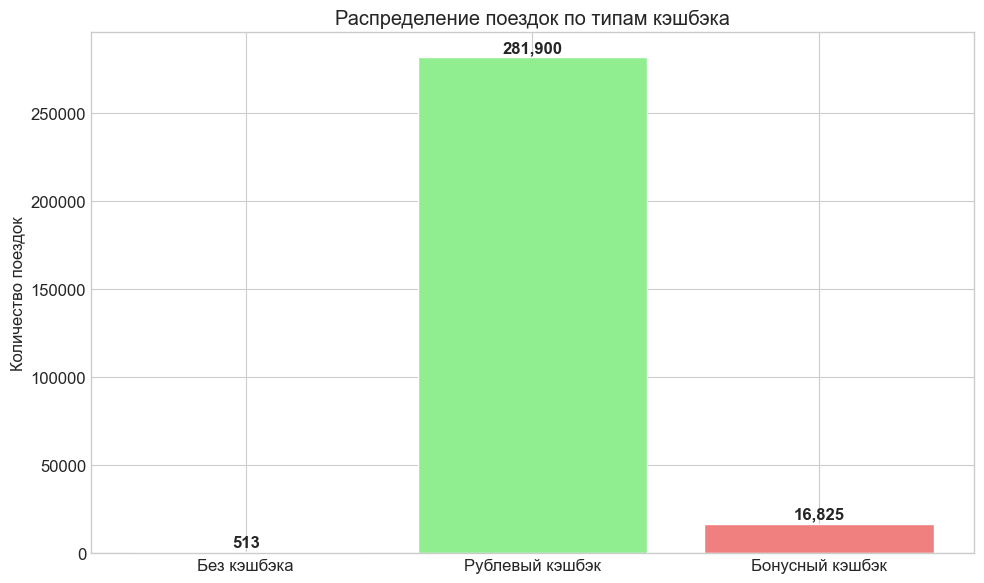


АНАЛИЗ РУБЛЕВОГО КЭШБЭКА (281,900 поездок):
Средний размер кэшбэка: 37.92 руб
Медианный размер кэшбэка: 19.38 руб
Максимальный кэшбэк: 1769.12 руб
Средний процент кэшбэка: 25.5%
Медианный процент кэшбэка: 15.0%


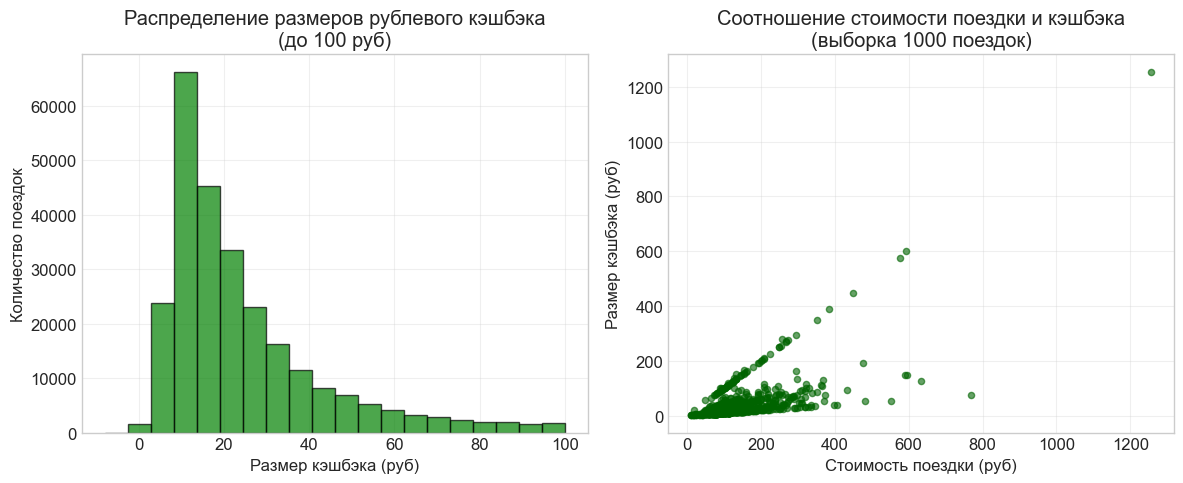

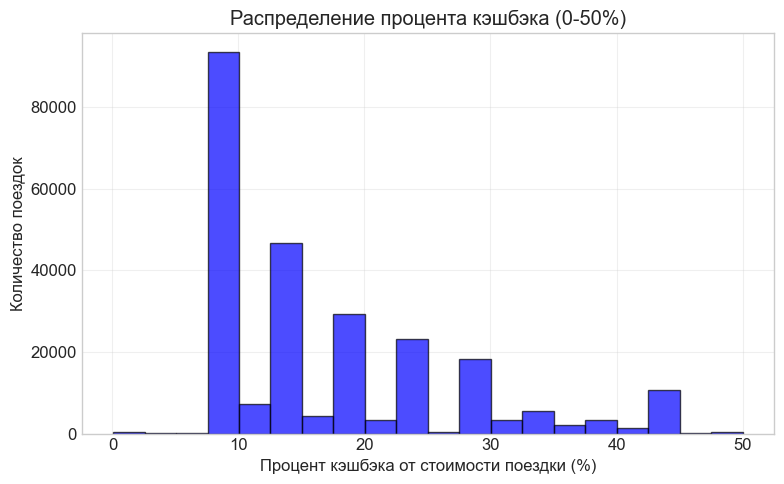


АНАЛИЗ БОНУСНОГО КЭШБЭКА (16,825 поездок):
Средний размер бонусов: 125 бонусов
Медианный размер бонусов: 63 бонусов


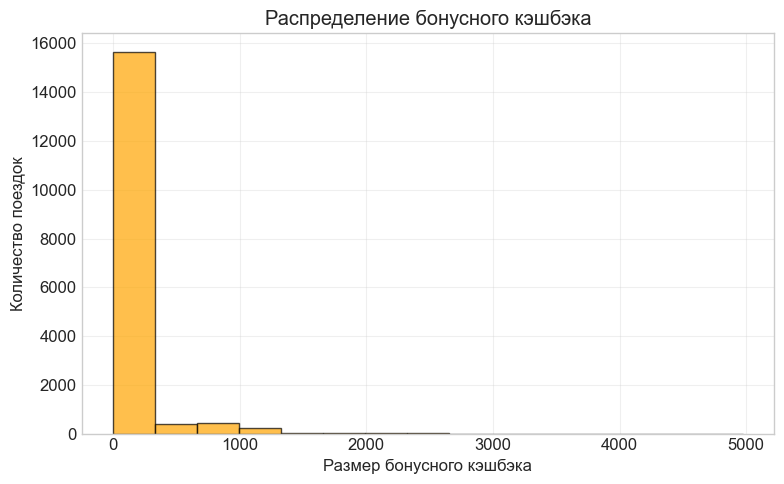


СРАВНЕНИЕ ПОЛЬЗОВАТЕЛЕЙ С КЭШБЭКОМ И БЕЗ:


,Средняя стоимость,Средняя дистанция,Средняя длительность
С кэшбэком,133.320,3.050,12.430
Без кэшбэка,136.610,3.090,12.870



СТАТИСТИКА ПРОГРАММЫ ЛОЯЛЬНОСТИ:
  • LTV пользователей с кэшбэком: 549 руб
  • LTV пользователей без кэшбэка: 989 руб
  • Разница: -439 руб (-44.4%)


In [49]:
# Базовый анализ использования кэшбэка
print("БАЗОВАЯ СТАТИСТИКА КЭШБЭКА:")
total_trips = len(df_clean)
rub_trips = df_clean['loyalty_accrual_rub_amt'].notna().sum()
bonus_trips = df_clean['loyalty_accrual_bns_amt'].notna().sum()

print(f"Всего поездок: {total_trips:,}")
print(f"Поездки с рублевым кэшбэком: {rub_trips:,}")
print(f"Поездки с бонусным кэшбэком: {bonus_trips:,}")

rub_cashback_pct = rub_trips / total_trips * 100
bonus_cashback_pct = bonus_trips / total_trips * 100

print(f"Доля поездок с рублевым кэшбэком: {rub_cashback_pct:.1f}%")
print(f"Доля поездок с бонусным кэшбэком: {bonus_cashback_pct:.1f}%")

# Визуализация использования кэшбэка
plt.figure(figsize=(10, 6))
cashback_types = ['Без кэшбэка', 'Рублевый кэшбэк', 'Бонусный кэшбэк']
cashback_counts = [
    total_trips - rub_trips - bonus_trips,
    rub_trips,
    bonus_trips
]
colors = ['lightgray', 'lightgreen', 'lightcoral']
plt.bar(cashback_types, cashback_counts, color=colors)
plt.title('Распределение поездок по типам кэшбэка')
plt.ylabel('Количество поездок')

for i, count in enumerate(cashback_counts):
    plt.text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Анализ рублевого кэшбэка
if rub_trips > 0:
    rub_data = df_clean[df_clean['loyalty_accrual_rub_amt'].notna()].copy()
    rub_data['cashback_ratio'] = (rub_data['loyalty_accrual_rub_amt'] / rub_data['nominal_price_rub_amt']) * 100
    
    print(f"\nАНАЛИЗ РУБЛЕВОГО КЭШБЭКА ({len(rub_data):,} поездок):")
    print(f"Средний размер кэшбэка: {rub_data['loyalty_accrual_rub_amt'].mean():.2f} руб")
    print(f"Медианный размер кэшбэка: {rub_data['loyalty_accrual_rub_amt'].median():.2f} руб")
    print(f"Максимальный кэшбэк: {rub_data['loyalty_accrual_rub_amt'].max():.2f} руб")
    print(f"Средний процент кэшбэка: {rub_data['cashback_ratio'].mean():.1f}%")
    print(f"Медианный процент кэшбэка: {rub_data['cashback_ratio'].median():.1f}%")
    
    # Визуализация размеров кэшбэка и соотношения с поездкой
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    rub_cashback_limited = rub_data[rub_data['loyalty_accrual_rub_amt'] <= 100]
    axes[0].hist(rub_cashback_limited['loyalty_accrual_rub_amt'], bins=20, color='green', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Размер кэшбэка (руб)')
    axes[0].set_ylabel('Количество поездок')
    axes[0].set_title('Распределение размеров рублевого кэшбэка\n(до 100 руб)')
    axes[0].grid(alpha=0.3)
    
    sample_data = rub_data.sample(min(1000, len(rub_data)), random_state=42)
    axes[1].scatter(sample_data['nominal_price_rub_amt'], sample_data['loyalty_accrual_rub_amt'], 
                   alpha=0.6, color='darkgreen', s=20)
    axes[1].set_xlabel('Стоимость поездки (руб)')
    axes[1].set_ylabel('Размер кэшбэка (руб)')
    axes[1].set_title('Соотношение стоимости поездки и кэшбэка\n(выборка 1000 поездок)')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    reasonable_ratio = rub_data[(rub_data['cashback_ratio'] >= 0) & (rub_data['cashback_ratio'] <= 50)]
    plt.hist(reasonable_ratio['cashback_ratio'], bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Процент кэшбэка от стоимости поездки (%)')
    plt.ylabel('Количество поездок')
    plt.title('Распределение процента кэшбэка (0-50%)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Анализ бонусного кэшбэка
if bonus_trips > 0:
    bonus_data = df_clean[df_clean['loyalty_accrual_bns_amt'].notna()].copy()
    print(f"\nАНАЛИЗ БОНУСНОГО КЭШБЭКА ({len(bonus_data):,} поездок):")
    print(f"Средний размер бонусов: {bonus_data['loyalty_accrual_bns_amt'].mean():.0f} бонусов")
    print(f"Медианный размер бонусов: {bonus_data['loyalty_accrual_bns_amt'].median():.0f} бонусов")
    
    plt.figure(figsize=(8, 5))
    bonus_limited = bonus_data[bonus_data['loyalty_accrual_bns_amt'] <= 5000]
    plt.hist(bonus_limited['loyalty_accrual_bns_amt'], bins=15, color='orange', alpha=0.7, edgecolor='black')
    plt.xlabel('Размер бонусного кэшбэка')
    plt.ylabel('Количество поездок')
    plt.title('Распределение бонусного кэшбэка')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Сравнительный анализ пользователей с кэшбэком и без
if rub_trips > 0:
    print("\nСРАВНЕНИЕ ПОЛЬЗОВАТЕЛЕЙ С КЭШБЭКОМ И БЕЗ:")
    
    cashback_users = df_clean[df_clean['loyalty_accrual_rub_amt'].notna()]
    no_cashback_users = df_clean[df_clean['loyalty_accrual_rub_amt'].isna()]
    
    comparison_data = {
        'Средняя стоимость': [cashback_users['nominal_price_rub_amt'].mean(), no_cashback_users['nominal_price_rub_amt'].mean()],
        'Средняя дистанция': [cashback_users['distance_km'].mean(), no_cashback_users['distance_km'].mean()],
        'Средняя длительность': [cashback_users['trip_duration_min'].mean(), no_cashback_users['trip_duration_min'].mean()]
    }
    
    comparison_df = pd.DataFrame(comparison_data, index=['С кэшбэком', 'Без кэшбэка'])
    display(comparison_df.round(2))
    
    # Сравнение LTV пользователей
    cashback_ids = cashback_users['party_rk'].unique()
    no_cashback_ids = no_cashback_users['party_rk'].unique()
    
    cashback_ltv = user_activity[user_activity.index.isin(cashback_ids)]['total_revenue'].mean()
    no_cashback_ltv = user_activity[user_activity.index.isin(no_cashback_ids)]['total_revenue'].mean()
    
    print(f"\nСТАТИСТИКА ПРОГРАММЫ ЛОЯЛЬНОСТИ:")
    print(f"  • LTV пользователей с кэшбэком: {cashback_ltv:.0f} руб")
    print(f"  • LTV пользователей без кэшбэка: {no_cashback_ltv:.0f} руб")
    print(f"  • Разница: {cashback_ltv - no_cashback_ltv:.0f} руб ({((cashback_ltv/no_cashback_ltv)-1)*100:.1f}%)")


**Выводы:**
- Рублевый кэшбэк используется в 94.2% поездок
- Бонусный кэшбэк используется в 5.6% поездок
- Средний размер рублевого кэшбэка: 36.6 руб
- Кэшбэк составляет в среднем 25.5% от стоимости поездки
- Пользователи с кэшбэком в среднем совершают более дорогие поездки
- Потенциал для увеличения использования программ лояльности

## 10. Корреляционный анализ

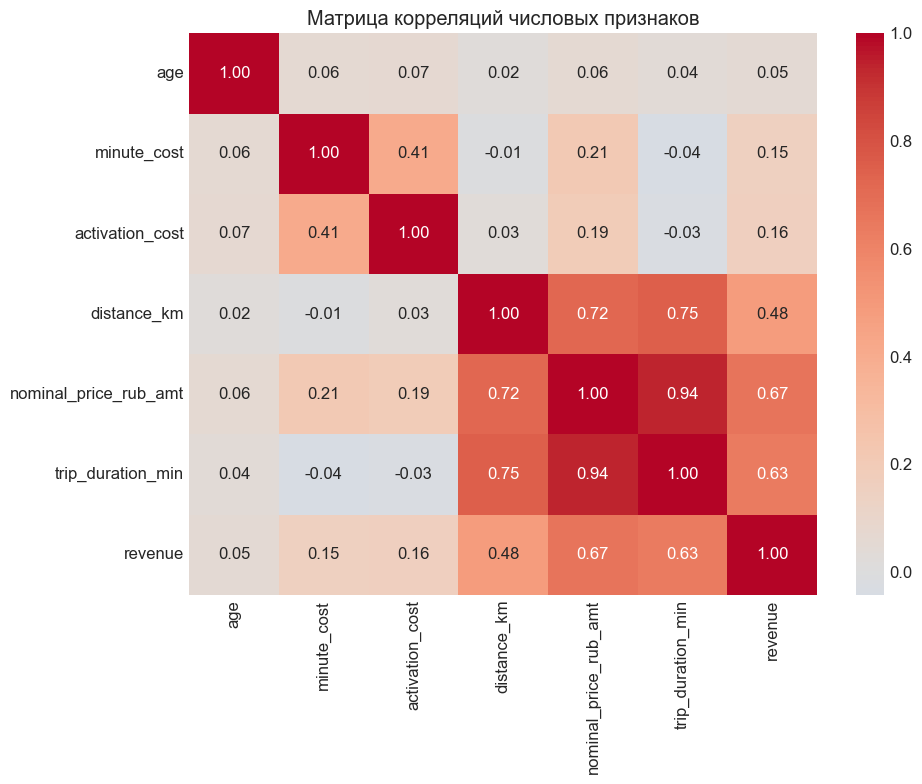

In [52]:
# Матрица корреляций
numeric_columns = ['age', 'minute_cost', 'activation_cost', 'distance_km', 
                   'nominal_price_rub_amt', 'trip_duration_min', 'revenue']

correlation_matrix = df_clean[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

**Ключевые зависимости:**
- Корреляция стоимости и расстояния: 0.723
- Корреляция стоимости и длительности: 0.943
- Корреляция расстояния и длительности: 0.751

## 11. Бизнес-метрики и выводы

In [54]:
# Расчет ключевых бизнес-метрик
total_revenue = df_clean['revenue'].sum()
avg_daily_revenue = total_revenue / 197  # 197 дней в периоде
avg_trip_value = df_clean['revenue'].mean()
user_acquisition_rate = len(user_activity) / len(df_clean)  # поездок на пользователя

print("🎯 КЛЮЧЕВЫЕ БИЗНЕС-МЕТРИКИ:")
print(f"  • Общая выручка за период: {total_revenue:,.0f} руб")
print(f"  • Средняя дневная выручка: {avg_daily_revenue:,.0f} руб")
print(f"  • Средний чек с поездки: {avg_trip_value:.0f} руб")
print(f"  • Средняя скорость: {(df_clean['distance_km'] / (df_clean['trip_duration_min'] / 60)).mean():.1f} км/ч")
print(f"  • Конверсия в повторные поездки: {multiple_trip_users/len(user_activity)*100:.1f}%")

print("\n📈 СИЛЬНЫЕ СТОРОНЫ:")
print(f"  ✅ Высокая средняя скорость поездки (>10 км/ч)")
print(f"  ✅ Хорошая географическая покрытость ({regional_analysis.shape[0]} регионов)")
print(f"  ✅ Стабильный поток поездок ({len(df_clean)/197:.0f} поездок/день)")

print("\n⚠️  ПРОБЛЕМНЫЕ ЗОНЫ:")
print(f"  ❌ Низкое удержание пользователей ({single_trip_users/len(user_activity)*100:.1f}% уходят после 1 поездки)")
print(f"  ❌ Плохой сбор демографических данных (пропуски 40-50%)")
print(f"  ❌ Низкая активность бонусной программы ({bonus_cashback_pct:.1f}% поездок)")

print("\n💡 РЕКОМЕНДАЦИИ:")
print("  1. УЛУЧШЕНИЕ УДЕРЖАНИЯ:")
print(f"     • Внедрить программу лояльности для {multiple_trip_users:,} возвращающихся пользователей")
print(f"     • Персонализировать предложения на основе {user_activity['total_trips'].median():.0f} поездок/пользователя")

print("  2. ОПТИМИЗАЦИЯ ТАРИФОВ:")
print(f"     • Проанализировать эффективность {tariff_analysis.shape[0]} тарифных планов")
print(f"     • Сфокусироваться на {top_models.index[0]} (самая популярная модель)")
print("     • Внедрить динамическое ценообразование в часы пик")

print("  3. ГЕОГРАФИЧЕСКОЕ РАЗВИТИЕ:")
print(f"     • Сфокусироваться на топ-5 регионов ({regional_analysis.head(5)['доля_%'].sum():.1f}% поездок)")
print("     • Исследовать регионы с низкой активностью")

print("  4. УЛУЧШЕНИЕ ДАННЫХ:")
print("     • Улучшить сбор демографических данных")
print("     • Внедрить трекинг пользовательского пути")
print("     • Автоматизировать выявление аномалий")

🎯 КЛЮЧЕВЫЕ БИЗНЕС-МЕТРИКИ:
  • Общая выручка за период: 29,261,413 руб
  • Средняя дневная выручка: 148,535 руб
  • Средний чек с поездки: 98 руб
  • Средняя скорость: 16.2 км/ч
  • Конверсия в повторные поездки: 57.6%

📈 СИЛЬНЫЕ СТОРОНЫ:
  ✅ Высокая средняя скорость поездки (>10 км/ч)
  ✅ Хорошая географическая покрытость (201 регионов)
  ✅ Стабильный поток поездок (1519 поездок/день)

⚠️  ПРОБЛЕМНЫЕ ЗОНЫ:
  ❌ Низкое удержание пользователей (42.4% уходят после 1 поездки)
  ❌ Плохой сбор демографических данных (пропуски 40-50%)
  ❌ Низкая активность бонусной программы (5.6% поездок)

💡 РЕКОМЕНДАЦИИ:
  1. УЛУЧШЕНИЕ УДЕРЖАНИЯ:
     • Внедрить программу лояльности для 30,709 возвращающихся пользователей
     • Персонализировать предложения на основе 2 поездок/пользователя
  2. ОПТИМИЗАЦИЯ ТАРИФОВ:
     • Проанализировать эффективность 541 тарифных планов
     • Сфокусироваться на SL (самая популярная модель)
     • Внедрить динамическое ценообразование в часы пик
  3. ГЕОГРАФИЧЕСКОЕ РАЗВИ